In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
c = sns.color_palette()
from sklearn import preprocessing, linear_model, model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVR
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
import xgboost as xgb

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

In [ ]:
print "train shape:", train.shape
print "test shape:", test.shape
print "submission shape:", submission.shape

In [ ]:
np.sort(train.X2.unique())

In [ ]:
np.sort(test.X2.unique())

In [ ]:
train

In [ ]:
dtype = train.dtypes.reset_index()
dtype.columns = ["count", "type"]
dtype.groupby("type").aggregate('count').reset_index()

In [ ]:
col_order = np.sort(train.X0.unique()).tolist()
plt.figure(figsize=(12,6))
sns.stripplot(x=train.X0, y=train.y, data=train, order = col_order)

In [ ]:
col_order = np.sort(train.X1.unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=train.X1, y=train.y, data=train, order = col_order)

In [ ]:
#col_order = np.sort(train.X2.unique()).tolist()
#plt.figure(figsize=(12,6))
#sns.swarmplot(x=train.X2, y=train.y, data=train, order = col_order)

In [ ]:
col_order = np.sort(train.X3.unique()).tolist()
plt.figure(figsize=(12,6))
sns.violinplot(x=train.X3, y=train.y, data=train, order = col_order)

In [ ]:
col_order = np.sort(train.X4.unique()).tolist()
plt.figure(figsize=(12,6))
sns.violinplot(x=train.X4, y=train.y, data=train, order = col_order)

In [ ]:
col_order = np.sort(train.X5.unique()).tolist()
plt.figure(figsize=(12,6))
sns.violinplot(x=train.X5, y=train.y, data=train, order = col_order)

In [ ]:
col_order = np.sort(train.X6.unique()).tolist()
plt.figure(figsize=(12,6))
sns.violinplot(x=train.X6, y=train.y, data=train, order = col_order)

In [ ]:
col_order = np.sort(train.X8.unique()).tolist()
plt.figure(figsize=(12,6))
sns.violinplot(x=train.X8, y=train.y, data=train, order = col_order)

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(train.ID, np.sort(train.y.values), color = 'r')
sns.regplot(train.ID,train.y, train, scatter_kws={'alpha':0.5, 's':20})
plt.xlabel('range')
plt.ylabel('y values')

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(train.y.values, bins=20)
plt.xlabel('y values')

In [ ]:
#Label encoding
#for c in train.columns:
#    if train[c].dtype == 'object':
        
#        lbl = LabelEncoder() 
#        lbl.fit(list(train[c].values) + list(test[c].values)) 
#        train[c] = lbl.transform(list(train[c].values))
#        test[c] = lbl.transform(list(test[c].values))
#y_train = train["y"]
#y_mean = np.mean(y_train)

In [ ]:
#One hot encoding
#for c in train.columns:
#    if train[c].dtype == 'object':
        
#        lbl = OneHotEncoder() 
#        lbl.fit(list(train[c].values) + list(test[c].values))
#        train[c] = lbl.transform(list(train[c].values))
#        test[c] = lbl.transform(list(test[c].values))
#y_train_df2 = train["y"]
#y_mean_df2 = np.mean(y_train)

In [ ]:
train = pd.get_dummies(train, columns=["X{}".format(x) for x in range(9) if x != 7])
test = pd.get_dummies(test, columns=["X{}".format(x) for x in range(9) if x != 7])

In [ ]:
y_train = train["y"]
y_mean = np.mean(y_train)

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
# retaining only those columns that are in train dataset
test = pd.DataFrame(test, columns=train.columns)

In [ ]:
test = test.drop(["y"], axis=1)

In [ ]:
#dropping all rows with missing values
for c in test.columns:
    if test[c].isnull().sum() > 0.5:
        test = test.drop([c], axis=1)

In [ ]:
train = pd.DataFrame(train, columns=test.columns)

In [ ]:
#converting all columns to int64
for c in train.columns:
    if train[c].dtype != 'int64':
        train[c] = train[c].apply(pd.to_numeric)

In [ ]:
for c in test.columns:
    if test[c].dtype != 'int64':
        test[c] = test[c].apply(pd.to_numeric)

In [ ]:
n_comp = 12

# PCA
pca = PCA(n_components=n_comp, random_state=400)
pca2_results_train = pca.fit_transform(train)
pca2_results_test = pca.transform(test)


for i in range(1, n_comp+1):
    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]

In [ ]:
y_train = pd.DataFrame(y_train)
train = pd.concat([train, y_train],axis=1)

In [ ]:
#xtrain, xtest, ytrain, ytest = train_test_split(train, y_train, test_size = 0.2, random_state = 0) #K-fold cross validation
#y_mean = np.mean(ytrain)

In [ ]:
xgb_params = {
    'n_trees': 1500, 
    'eta': 0.007,
    'max_depth': 4, 
    'subsample': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}

dtrain = xgb.DMatrix(train.drop('y', axis=1), y_train)
dtest = xgb.DMatrix(test)

cv_result = xgb.cv(xgb_params, dtrain, nfold = 10, num_boost_round=1500, early_stopping_rounds=20,
    verbose_eval=True, show_stdv=False)

num_boost_rounds = len(cv_result)

print num_boost_rounds

#num_boost_rounds = 2250
# train model

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

#from sklearn.metrics import r2_score
#print(r2_score(model.predict(dtrain), dtrain.get_label()))

y_pred = model.predict(dtest)

print label
#output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
#output.to_csv('submission_baseLine15.csv', index=False)

#xgb_params = {
#    'eta': 0.05,
#    'max_depth': 6,
#    'subsample': 0.7,
#    'colsample_bytree': 0.7,
#    'objective': 'reg:linear',
#    'silent': 1
#}

In [ ]:
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()

#print(r2_score(y_pred, dtest.get_label()))

In [ ]:
#model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
#y_pred = model.predict(dtest)

output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('submission_xgb.csv', index=False)

In [ ]:
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
#def xgb_r2_score(preds, dtrain):
#    labels = dtrain.get_label()
#    return 'r2', r2_score(labels, preds)

#print xgb_r2_score()

In [ ]:
train_x = train.drop('y', axis=1)


In [ ]:
from sklearn import ensemble
model = ensemble.RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(train_x, y_train)
feat_names = train_x.columns.values

feats = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(feats)[::-1][:50]

plt.figure(figsize=(12,12))
plt.title("feature importance")
plt.bar(range(len(indices)), feats[indices], color="b", align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [ ]:
model = SVR(kernel='poly', degree=3,gamma='auto', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1,
           shrinking=True, cache_size=200, verbose=False, max_iter=-1)
svr_model = model.fit(train.drop('y', axis=1), y_train)
#z = model.predict(train.drop('y', axis=1))
y_pred = svr_model.predict(test)
output['y'] = y_pred
output.to_csv('svr_model1.csv', index=False)
print(r2_score(y_pred))
output.head()

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


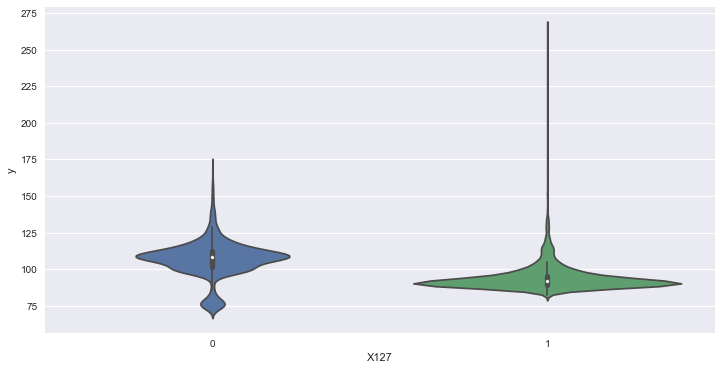

In [190]:
#inspect X127
train.X127.unique()

col_order = np.sort(train.X127.unique()).tolist()
plt.figure(figsize=(12,6))
sns.violinplot(x=train.X127, y=train.y, data=train, order = col_order)

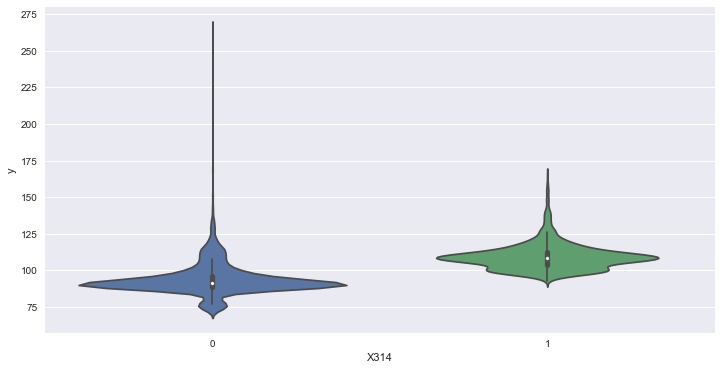

In [192]:
#inspect X314
train.X314.unique()
col_order = np.sort(train.X314.unique()).tolist()
plt.figure(figsize=(12,6))
sns.violinplot(x=train.X314, y=train.y, data=train, order = col_order)

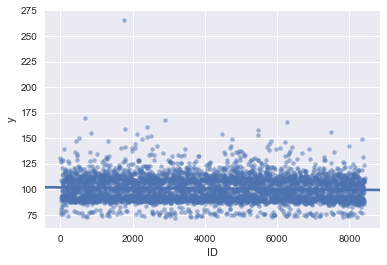

In [243]:
# Inspect ID

sns.regplot(train.ID,train.y, train, scatter_kws={'alpha':0.5, 's':20})

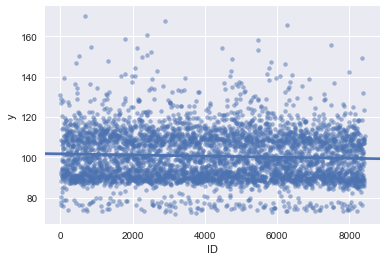

In [250]:
train_df = train
train_df.loc[train_df.y >250, 'y'] = 100
sns.regplot(train_df.ID,train_df.y, train_df, scatter_kws={'alpha':0.5, 's':20})

In [286]:
# Lasso and Ridge regularization
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [271]:
xRid_train, xRid_test, yRid_train, yRid_test = model_selection.train_test_split(train_x, train.y,random_state=42)
#stdScaler = StandardScaler()
#stdScaler.fit(xRid_train)
#xRid_train_scaled = stdScaler.transform(xRid_train)
#xRid_test_scaled = stdScaler.transform(xRid_test)

In [269]:
#len(xRid_test_scaled)

1053

In [258]:
#param_grid = {'alpha': [100,10,1,5,0.1,0.01,0.001,0.0001,0]}
#grid =  GridSearchCV(Ridge(), param_grid, cv =5)
#grid.fit(xRid_train_scaled, yRid_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [100, 10, 1, 5, 0.1, 0.01, 0.001, 0.0001, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [259]:
#print("Best parameters: {}".format(grid.best_params_))
#print("Best cross-validation score: {:.3f}".format(grid.best_score_))

Best parameters: {'alpha': 100}
Best cross-validation score: 0.559


In [260]:
#print("The R^2 on the training set:  {:.6f}".format(grid.score(xRid_train_scaled, yRid_train)))
#print("The R^2 on the test set:  {:.6f}".format(grid.score(xRid_test_scaled, yRid_test)))

The R^2 on the training set:  0.626613
The R^2 on the test set:  0.531136


In [272]:
from sklearn.pipeline import make_pipeline 
pipe  =  make_pipeline(StandardScaler(), Ridge())
param_grid = {'ridge__alpha': [100,10,1,0.1,0.01,0.001,0.0001,0]}
grid_pipe =  GridSearchCV(pipe, param_grid, cv=5)
grid_pipe.fit(xRid_train, yRid_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [273]:
print("Best parameters: {}".format(grid_pipe.best_params_))
print("Best Cross-validation RMS: {:.3f}".format(grid_pipe.best_score_))
#print("Test Best Score: {:.3f}".format(grid.score(X_test, Y_test)))

Best parameters: {'ridge__alpha': 100}
Best Cross-validation RMS: 0.558


In [274]:
print("The R^2 on the training set:  {:.6f}".format(grid_pipe.score(xRid_train_scaled, yRid_train)))
print("The R^2 on the test set:  {:.6f}".format(grid_pipe.score(xRid_test_scaled, yRid_test)))

The R^2 on the training set:  -32.572108
The R^2 on the test set:  -27.704944


In [283]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, xRid_train, yRid_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

model_lasso = Lasso()

In [354]:
lasso = LassoCV(alphas = np.logspace(-3,2,100), max_iter = 10000, cv = 10).fit(xRid_train, yRid_train)
alpha = lasso.alpha_

alpha = LassoCV(alphas = [alpha*0.6, alpha * .75, alpha * .9, alpha, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], cv = 10).fit(xRid_train, yRid_train).alpha_

print("Lasso alpha: ", alpha)

#print("RMSE :", rmse_cv(lasso).mean())

y_train_las = lasso.predict(xRid_train)
y_test_las = lasso.predict(xRid_test)

('Lasso alpha: ', 0.026235477565426581)


NameError: global name 'cross_val_score' is not defined